In [3]:
import pandas as pd
%matplotlib inline
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [4]:
data_path="./data/"
data=pd.read_csv(data_path+'tesco.csv',index_col='area_id')
data=data.query('month=="yea"')#We consider the data collected over the enitire year
data=data.query('agg_level=="lsoa"')#To be as precise as possible we will study the smallest aggregation level
data=data.drop(columns=['month','agg_level'])
data.head()

,fat,saturate,sugar,protein,carb,fibre,energy_tot,h_nutrients_calories
area_id,,,,,,,,
E01000001,8.535149,3.498749,9.213734,5.262429,15.158014,1.622653,163.985327,1.620439
E01000002,8.054729,3.159077,8.337412,5.351774,14.358466,1.692822,157.572172,1.661276
E01000003,8.153757,3.375788,9.414937,5.029519,15.820254,1.522523,163.321285,1.646243
E01000005,8.339058,3.319496,9.603258,5.230254,17.126487,1.612862,169.339310,1.595496
E01000006,9.622101,3.864007,11.355115,5.026295,19.903063,1.640227,190.310015,1.519193


In [5]:
kmean = KMeans(n_clusters=2, random_state=42).fit(data)

In [8]:
silhouettes = []
# Try multiple k
for k in range(2, 11):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(data)
    # Get the Silhouette score
    score = silhouette_score(data, labels)
    silhouettes.append({"k": k, "score": score})
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)
sse = []
for k in range(1, 10):
    # Assign the labels to the clusters
    kmeans = KMeans(n_clusters=k, random_state=10).fit(data)
    sse.append({"k": k, "sse": kmeans.inertia_})
sse = pd.DataFrame(sse)

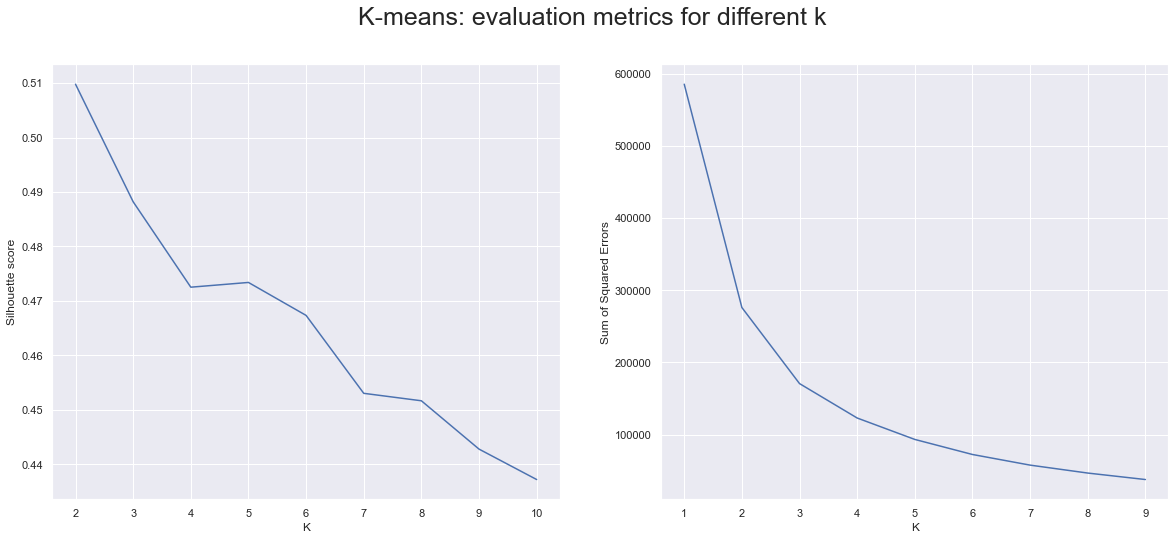

In [22]:
fig, axs = plt.subplots(2, 1, figsize=(20,8))
# Plot the data
plt.subplot(121)
sns.lineplot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")
# Plot the data
plt.subplot(122)
sns.lineplot(sse.k, sse.sse)
plt.xlabel("K")
plt.ylabel("Sum of Squared Errors")
fig.suptitle("K-means: evaluation metrics for different k",fontsize=25)
plt.show()

In [16]:
k=7

In [17]:
X_reduced_pca  = PCA(n_components=2).fit(data).transform(data)
X_reduced_tsne = TSNE(n_components=2, random_state=0).fit_transform(data)

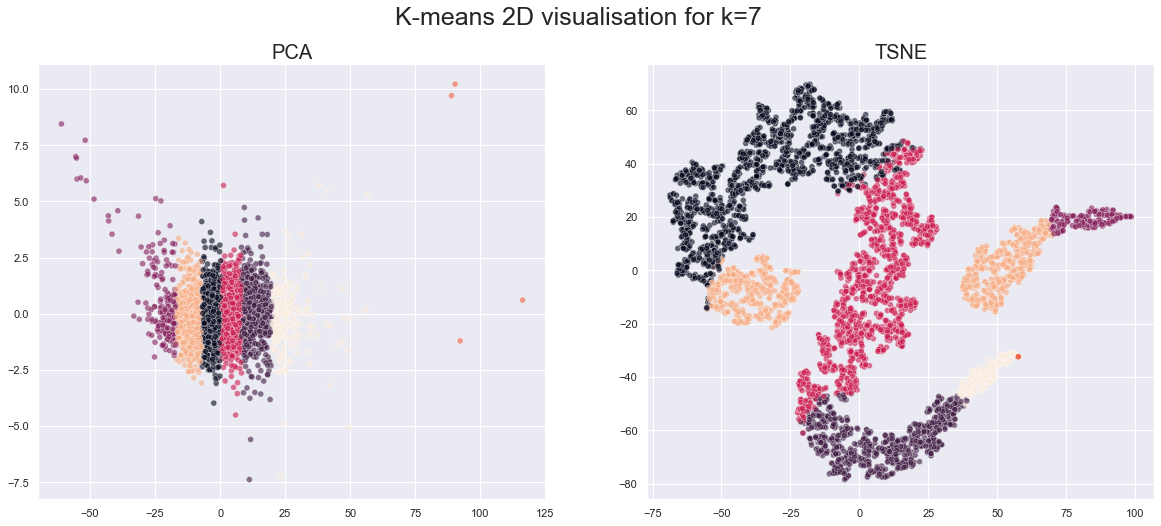

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(20,8))
labels = KMeans(n_clusters=k, random_state=42).fit_predict(data)
plt.subplot(121)
ax = sns.scatterplot(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels, alpha=0.6)
ax.set_title("PCA",fontsize=20)
plt.subplot(122)
ax = sns.scatterplot(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=labels, alpha=0.6)
ax.set_title("TSNE",fontsize=20)
fig.suptitle("K-means 2D visualisation for k=7",fontsize=25)
plt.show()

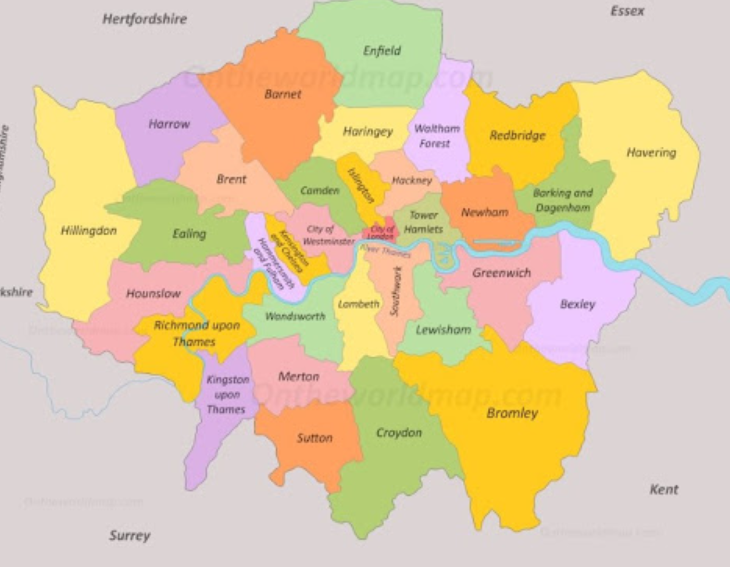

# Write back  dataset with clusters

In [23]:
df=pd.read_csv('data/tesco.csv') 
max_k=8
agg_levels=np.unique(df['agg_level'])
typical_products=[ 'fat', 'saturate', 'sugar', 'protein', 'carb', 'fibre','energy_tot', 'h_nutrients_calories']
for k in range(2,max_k+1):
    new_col_name='cluster_'+str(k)
    df[new_col_name]='No data'
df.head(1)

,area_id,fat,saturate,sugar,protein,carb,fibre,energy_tot,h_nutrients_calories,month,agg_level,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,E09000001,8.472985,3.361599,9.278065,5.253333,15.779639,1.61985,165.851751,1.618208,yea,borough,No data,No data,No data,No data,No data,No data,No data


In [24]:
for lvl in agg_levels:
    current_data=df[(df.month == 'yea') * (df.agg_level ==lvl)]
    for k in range(2,max_k+1):
        labels = KMeans(n_clusters=k, random_state=42).fit_predict(current_data[typical_products])
        col_name='cluster_'+str(k)
        df.loc[current_data.index,col_name]=labels


In [25]:
df.to_csv('data/tesco_cluster.csv',index=False)

# Cluster analysis

In [26]:
def add_clusters(gdf):
    cols = [c for c in df.columns if c.startswith("cluster")]
    out = gdf.merge(df[['area_id']+cols],on='area_id',how='inner').query("cluster_2 != 'No data'")
    out[cols] = out[cols].astype('int')
    out = out.reset_index()
    for k in range(2,max_k +1):
        out['cluster_random_'+str(k)] = np.random.randint(k, size=len(out))
    return out

In [27]:
import pandas as pd
import geopandas as gpd
import numpy as np
data_path = 'data/statistical-gis-boundaries-london/ESRI2/'
gdf_lsoa = gpd.read_file(data_path + 'LSOA_2011_London_gen_MHW.shp' )[['LSOA11CD','geometry']]\
                .rename(columns={'LSOA11CD':'area_id'})
gdf_lsoa = gdf_lsoa.reset_index()
gdf = add_clusters(gdf_lsoa)
gdf.head(4)

,level_0,index,area_id,geometry,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_random_2,cluster_random_3,cluster_random_4,cluster_random_5,cluster_random_6,cluster_random_7,cluster_random_8
0,2,0,E01000001,"POLYGON ((532105.092 182011.230, 532162.491 18...",0,2,2,2,5,2,2,0,0,1,2,0,4,7
1,15,1,E01000002,"POLYGON ((532746.813 181786.891, 532671.688 18...",0,2,2,2,5,2,2,1,1,1,1,2,3,3
2,28,2,E01000003,"POLYGON ((532135.145 182198.119, 532158.250 18...",0,2,2,2,5,2,2,1,2,3,3,4,6,4
3,41,3,E01000005,"POLYGON ((533807.946 180767.770, 533649.063 18...",0,2,2,4,2,5,0,1,2,1,1,0,0,5


## Comparaison random graph

In [66]:
def add_neighbors_clusters(gdf):
    cols = [c for c in gdf.columns if c.startswith("cluster")]
    l = [None] *len(gdf)
    for idx, row in gdf.iterrows():
        neighbors = gdf[~gdf.geometry.disjoint(row.geometry)][['area_id']+cols]\
            .query("area_id != '"+str(row.area_id)+"'")[cols]
        l[idx] = np.sum(neighbors == row[cols])
    
    tmp = pd.concat(l,axis=1).T.rename(
        columns={c:'cluster_border_neighbors_'+("random_" if c.find('random')!=-1 else "")+c[-1] 
                 for c in cols})
    return pd.concat((gdf,tmp),axis=1)

In [67]:
neighbors = add_neighbors_clusters(gdf)

In [99]:
def create_border_scores(gdf):
    l = []
    for k in range(2,max_k+1):
        # mean border scores
        col       = "cluster_"+str(k)
        score_col = "cluster_border_neighbors_" + str(k)
        sdf = gdf.groupby(col)[score_col].mean()\
            .drop(columns=['index'])\
            .rename('mean_border_score_'+str(k))
        # random assignment
        random_col       = 'cluster_random_'+str(k)
        random_score_col = "cluster_border_neighbors_random_" + str(k)
        random_mean      = gdf.groupby(random_col)[random_score_col]\
                                .mean()\
                                .mean()
        #create output pd series
        l.append(sdf.append(pd.Series({'random':random_mean})))
    out = pd.concat(l,axis=1)
    out = out.rename(columns={c:"cluster_"+str(int(c)+2) for c in out.columns})
    out.index = out.index.astype(str)
    return out.sort_index()

In [100]:
mean_borders = create_border_scores(neighbors)
mean_borders.to_csv('data/mean_border_score.csv',index=False)
mean_borders

,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8
0,4.283726,3.545064,3.275125,2.734783,2.568956,2.360133,2.444638
1,3.388767,2.537017,2.526681,0.821429,1.398964,2.008264,1.797557
2,NaN,3.139927,2.730583,2.157480,2.683307,1.980769,2.089005
3,NaN,NaN,1.302452,2.278826,0.000000,2.179195,1.815962
4,NaN,NaN,NaN,2.840268,2.043400,0.000000,0.866242
5,NaN,NaN,NaN,NaN,2.129450,2.235294,2.280161
6,NaN,NaN,NaN,NaN,NaN,0.906977,0.000000
7,NaN,NaN,NaN,NaN,NaN,NaN,2.153846
random,2.718506,1.819785,1.373494,1.096485,0.931313,0.786927,0.688966


##  Visualisation

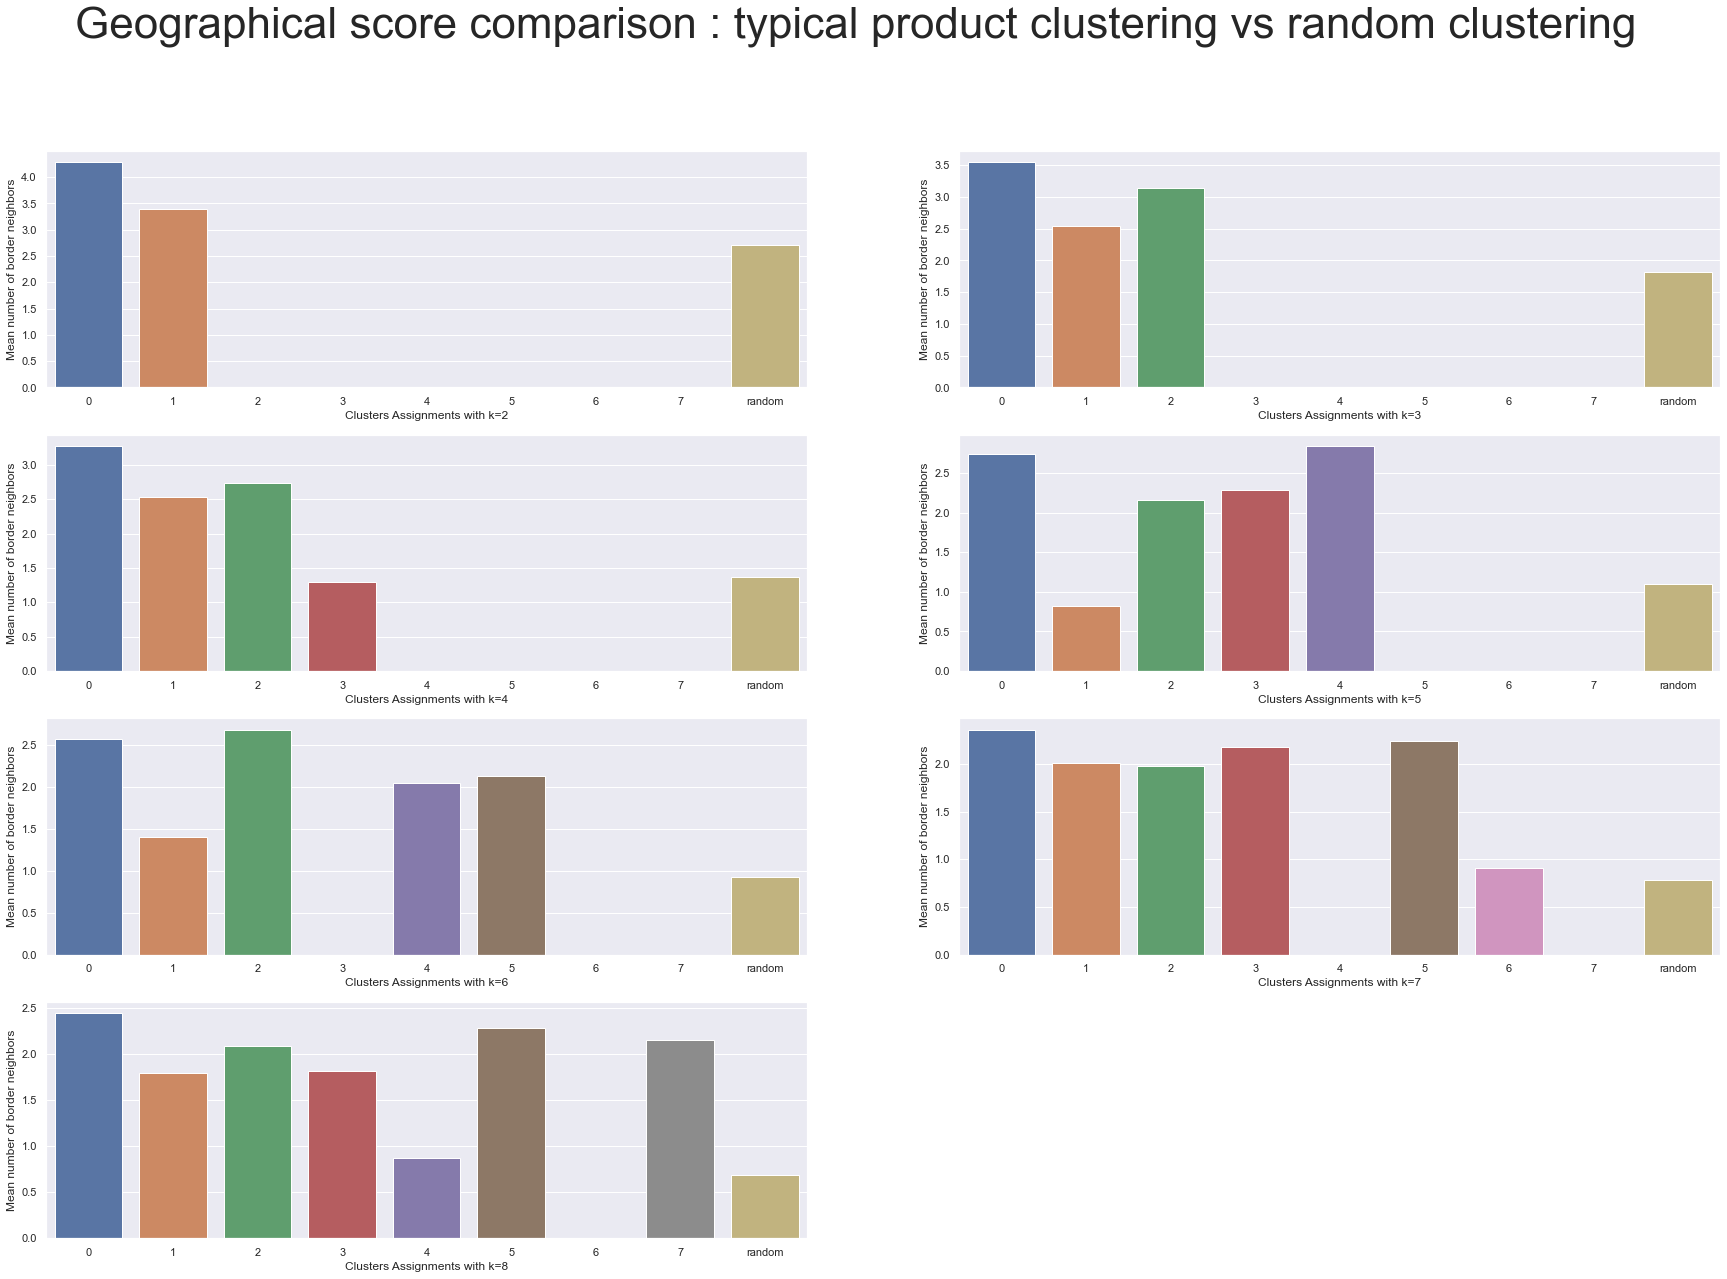

In [112]:
fig, axs = plt.subplots(2, 1, figsize=(30,20))
for i in range(1,8):
    plt.subplot(4,2,i)
    ax = sns.barplot(x = mean_borders.index, y="cluster_"+str(i+1),data=mean_borders)
    ax.set_xlabel("Clusters Assignments with k = "+str(i+1))
    ax.set_ylabel("Mean number of border neighbors")
    #g.add_legend()
fig.suptitle("Geographical score comparison : typical product clustering vs random clustering", fontsize=44)
plt.show()

## Geographic silhouette

In [40]:
geo_coords  = gdf_lsoa.geometry.centroid.apply(lambda p: pd.Series({'x':p.x,'y':p.y}))
geo_coords['area_id'] = gdf_lsoa.area_id
geo_coords  = geo_coords.merge(data,on='area_id',how='inner')[['x','y']]
silhouettes = []
# Try multiple k
for k in range(2, 20):
    labels = KMeans(n_clusters=k, random_state=42).fit_predict(data)
    # Get the Silhouette score
    geo_score  = silhouette_score(geo_coords, labels)
    silhouettes.append({"k": k, "geo_score": geo_score, "Clustering Type":"k-means"})
    #random graph comparison
    rnd_score = silhouette_score(geo_coords, np.random.randint(k, size=len(labels)))
    silhouettes.append({"k": k, "geo_score": rnd_score, "Clustering Type":"random"})
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)
silhouettes.head(3)

,k,geo_score,Clustering Type
0,2,0.102800,k-means
1,2,0.000190,random
2,3,-0.028515,k-means


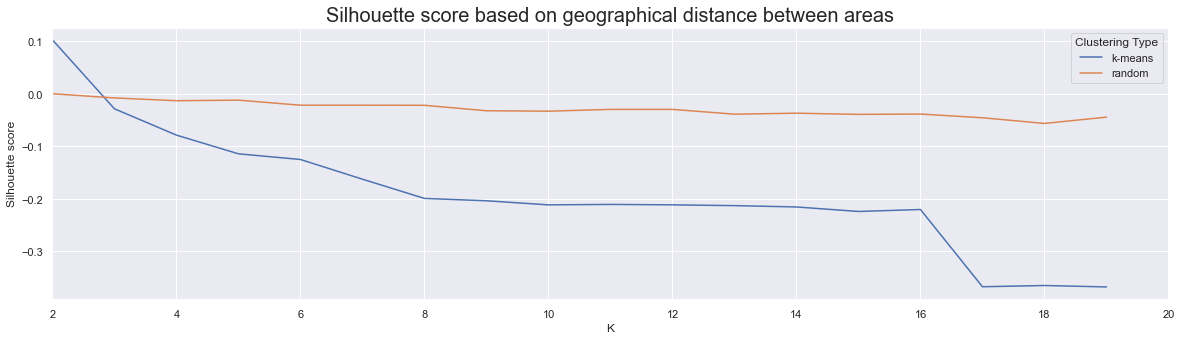

In [48]:
plt.figure(figsize=(20,5))
# Plot the data
ax = sns.lineplot(data=silhouettes, x='k', y='geo_score', hue="Clustering Type")
ax.set_xlabel("K")
ax.set_ylabel("Silhouette score")
ax.set_xlim((2,20))
plt.title("Silhouette score based on geographical distance between areas",fontsize=20)
plt.show()